<a href="https://www.kaggle.com/mohamedbakrey/mnist-by-using-autoencoder?scriptVersionId=88986154" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# introduction
 
# Building an autoencoder using Keras
    We're now going to move onto something really exciting, building an autoencoder
    using the tf.keras library. For simplicity, we'll be using the MNIST dataset for the
    first set of examples. The autoencoder will then generate a latent vector from the
    input data and recover the input using the decoder. The latent vector in this first
    example is 16-dim.

## Firstly, we're going to implement the autoencoder by building the encoder

    shows the encoder that compresses the MNIST digit into a 16-dim
    latent vector. The encoder is a stack of two Conv2D. The final stage is a Dense layer
    with 16 units to generate the latent vector.

# import Library and Data 

In [36]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

In [37]:
# load MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()

In [38]:
print("train data:",x_train.shape)
print("test data:",x_test.shape)

train data: (60000, 28, 28)
test data: (10000, 28, 28)


In [39]:
# reshape to (28, 28, 1) and normalize input images
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])

In [40]:
print("train after reshape:",x_train.shape)
print("test after reshape:",x_test.shape)

train after reshape: (60000, 28, 28, 1)
test after reshape: (10000, 28, 28, 1)


In [41]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

### Set input Parametre

In [42]:
# network parameters
input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
latent_dim = 16
# encoder/decoder number of CNN layers and filters per layer
layer_filters = [32, 64]

# Build The autoencoder model

In [43]:
# build the autoencoder model
# first build the encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# stack of Conv2D(32)-Conv2D(64)
for filters in layer_filters:
    x = Conv2D(filters=filters,
    kernel_size=kernel_size,
    activation='relu',
    strides=2,
    padding='same')(x)

In [44]:
# shape info needed to build decoder model
# so we don't do hand computation
# the input to the decoder's first
# Conv2DTranspose will have this shape
# shape is (7, 7, 64) which is processed by
# the decoder back to (28, 28, 1)
shape = K.int_shape(x)
shape

(None, 7, 7, 64)

In [45]:
# generate latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)
# instantiate encoder model
encoder = Model(inputs,
latent,
name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_2 (Flatten)          (None, 3136)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 16)                50192     
Total params: 69,008
Trainable params: 69,008
Non-trainable params: 0
_________________________________________________________________


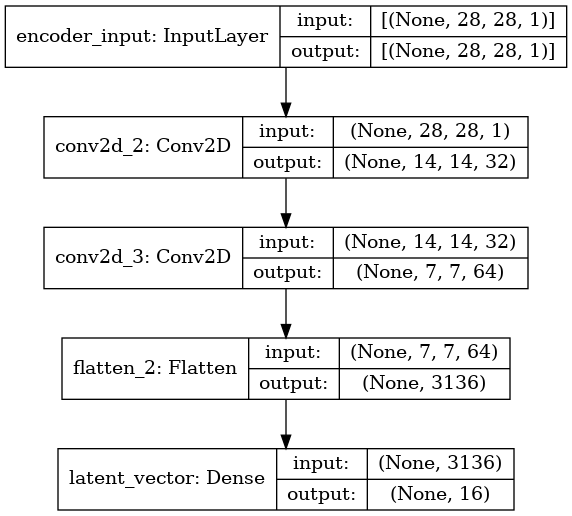

In [46]:
plot_model(encoder,
                    to_file='encoder.png',
                    show_shapes=True)

# Build The Decoder

In [47]:
# build the decoder model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
# use the shape (7, 7, 64) that was earlier saved
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
# from vector to suitable shape for transposed conv
x = Reshape((shape[1], shape[2], shape[3]))(x)

In [48]:
# stack of Conv2DTranspose(64)-Conv2DTranspose(32)
for filters in layer_filters[::-1]:
            x = Conv2DTranspose(filters=filters, kernel_size=kernel_size,activation='relu',strides=2,  padding='same')(x)

In [49]:
# reconstruct the input
outputs = Conv2DTranspose(filters=1,
                                    kernel_size=kernel_size,
                                    activation='sigmoid',
                                    padding='same',
                                    name='decoder_output')(x)

In [50]:
# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()


Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 16)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              53312     
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 28, 28, 1)         289       
Total params: 108,993
Trainable params: 108,993
Non-trainable params: 0
_____________________________________________________

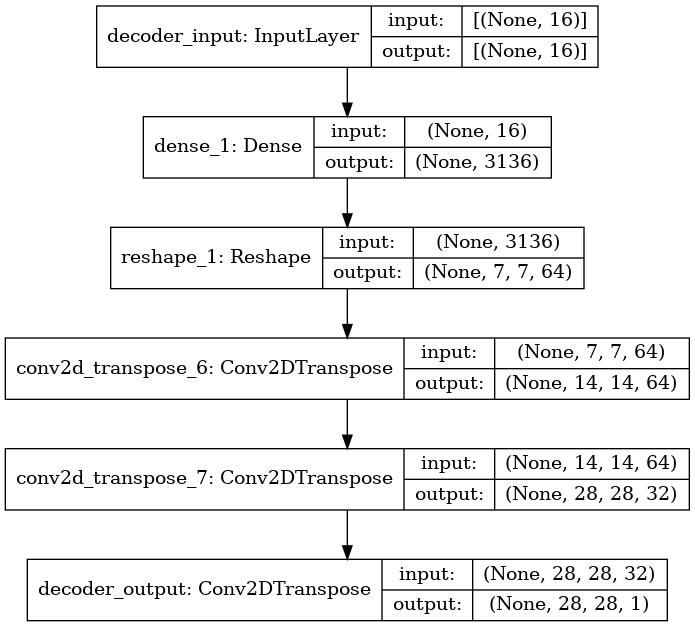

In [51]:
plot_model(decoder, to_file='decoder.png', show_shapes=True)

In [52]:
# autoencoder = encoder + decoder
# instantiate autoencoder model
autoencoder = Model(inputs,
                            decoder(encoder(inputs)),
                            name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Functional)         (None, 16)                69008     
_________________________________________________________________
decoder (Functional)         (None, 28, 28, 1)         108993    
Total params: 178,001
Trainable params: 178,001
Non-trainable params: 0
_________________________________________________________________


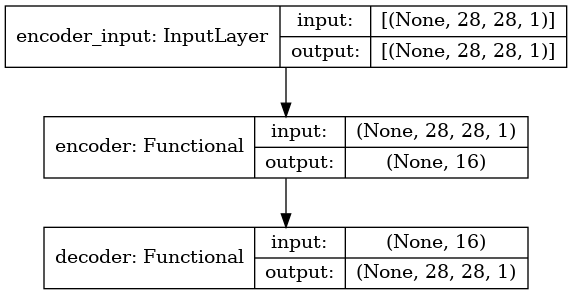

In [53]:
plot_model(autoencoder,
                        to_file='autoencoder.png',
                        show_shapes=True)

### Make acompile by using Mean Square error and loss function and using optimizer (Adam)

In [54]:
# Mean Square Error (MSE) loss function, Adam optimizer
autoencoder.compile(loss='mse', optimizer='adam')

In [55]:
# train the autoencoder
autoencoder.fit(x_train,
                        x_train,
                        validation_data=(x_test, x_test),
                        epochs=1,
                        batch_size=batch_size)

1875/1875 [==============================] - 53s 28ms/step - loss: 0.0212 - val_loss: 0.0102


In [56]:
# predict the autoencoder output from test data
x_decoded = autoencoder.predict(x_test)

In [70]:
# display the 1st 8 test input and decoded images
imgs = np.concatenate([x_test[:8], x_decoded[:8]])
imgs = imgs.reshape((4, 4, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

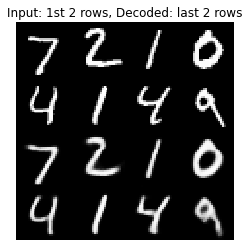

In [67]:
plt.axis('off')
plt.title('Input: 1st 2 rows, Decoded: last 2 rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.savefig('input_and_decoded.png')
plt.show()